# Example on Solar System Dynamics (small bodies)

- introduction to simulation parameters
- save output using SimulationArchive
- standard/simple workflow

In [1]:
import math
import numpy as np

import rebound

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

import time
from datetime import datetime, timedelta
from astropy import units as u
from astropy.constants import M_sun, au


# SOME CONSTANTS
lunar = 389.177939646 # au in lunar distance
year_to_day = 365.256363004 # Earth sidereal revolution period
# One year in units where G=1, for conversion of the unit used in Rebound, (4*pi**2 / (1 + M_earth))
year = 6.2831758714599477 
au = au.value
M_sun = M_sun.value
GOLDEN_RATIO = 0.5*(1. + np.sqrt(5))    

# PLOTTING
matplotlib.rcParams.update({'text.usetex': True})
matplotlib.rcParams.update({'font.size': 20})

%matplotlib inline

### Init simulation

In [2]:
sim = rebound.Simulation()

### We want to simulate Solar System and to know Apophis orbital dynamics

In [3]:
asteroidname="Apophis"
initdate="2017-08-17 00:00"
tend=100.0 # year

### Add particles to the simulation

- by downloading ephemeris from JPL NASA Horizons database

In [4]:
# download initial condition from JPL NASA Horizons 
sim.add("Sun", date=initdate) 
sim.add("Mercury", date=initdate)
sim.add("Venus", date=initdate)
sim.add("399", date=initdate) # Earth
sim.add("301", date=initdate) # Moon
sim.add("Mars", date=initdate)
sim.add("Jupiter", date=initdate)
sim.add("Saturn", date=initdate)
sim.add("Uranus", date=initdate)
sim.add("Neptune", date=initdate)
sim.add(asteroidname, date=initdate) # asteroid has last index [-1] in sim.particles

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Venus Barycenter (299).
Searching NASA Horizons for '399'... Found: Earth (399).
Searching NASA Horizons for '301'... Found: Moon (301).
Searching NASA Horizons for 'Mars'... Found: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).
Searching NASA Horizons for 'Apophis'... Found: 99942 Apophis (2004 MN4).


/scratch/home/rwibowo/anaconda3/lib/python3.6/site-packages/rebound/horizons.py:140: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


In [5]:
ps = sim.particles 

In [6]:
ps[-1]

<rebound.Particle object, m=0.0 x=-1.0363293247447078 y=0.34742825413006256 z=-0.04304063681695255 vx=-0.2340414682112937 vy=-0.8286442341864902 vz=0.038583493153013695>

### Add radius of particles for collision detection

Radius is not retrieved from JPL NASA using above script.

In [7]:
ps[0].r = 695700/au
ps[1].r = 2440/au
ps[2].r = 6052/au
ps[3].r = 6378/au
ps[4].r = 1737/au
ps[5].r = 3390/au
ps[6].r = 69911/au
ps[7].r = 58232/au
ps[8].r = 25362/au
ps[9].r = 24622/au

### Set parameters before integration

In [8]:
# Setting
sim.integrator = "ias15" # IAS15 is the default integrator, so we actually don't need this line
sim.dt = 0.001           # IAS15 use the adaptive timestep
sim.collision = "direct" # direct nearest-neighbor search
sim.collision_resolve = "merge" # if collision happen, merge 2 particles
sim.move_to_com()

tmax = tend*year # end of simulation (in year)
Noutput = 10000

/scratch/home/rwibowo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


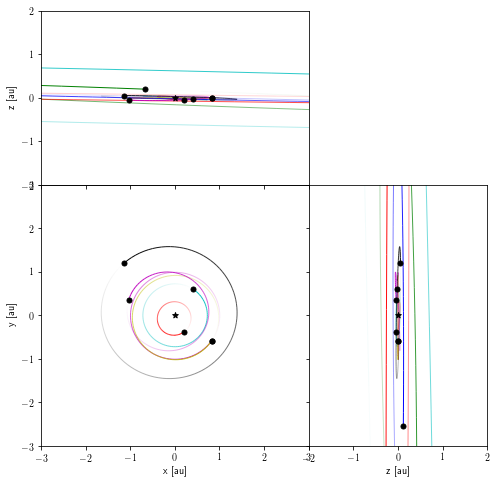

In [9]:
fig = rebound.OrbitPlot(sim, slices=True, trails=True, color=True, unitlabel="[au]", 
                        lim=3.0, limz=3.0*0.6667, plotparticles='')
plt.show()

### Set how to save the data

In [10]:
sim.automateSimulationArchive(asteroidname+".bin", interval=tmax/Noutput, deletefile=True) 
# save in 'special' binary format (H. rain, D. Tamayo, 2017)

### Integrate!

In [11]:
print("Number of particles before integration: ", len(ps))
sim.integrate(tmax, exact_finish_time=0) # simulate
print("Number of particles after integration: ", len(ps))

print("Integration finish.")
resolutiontime = (tend)*year_to_day*24./Noutput
print("Resolution of the saved data = %f hour" % (resolutiontime))

Number of particles before integration:  11
Number of particles after integration:  11
Integration finish.
Resolution of the saved data = 87.661527 hour


### Analysis

In [12]:
def get_daeiw(sa):
    # calc d, a, e, i, w as function of t
    times = np.zeros(len(sa))
    daeiw = np.zeros((8, len(sa))) # 8 parameters to be calculated/saved
    for i, sim in enumerate(sa):
        times[i] = sim.t
        d = sim.particles[-1] - sim.particles[3] # asteroid - earth
        dist = np.sqrt(d.x*d.x + d.y*d.y + d.z*d.z)
        azimuth = math.atan2(d.y, d.x)
        
        # For rotating frame
        ds = sim.particles[-1] - sim.particles[0] # heliocentric distance 
        de = sim.particles[3] - sim.particles[0]
        azs = math.atan2(ds.y, ds.x)
        aze = math.atan2(de.y, de.x)
        azr = azs - aze
        drot = np.sqrt(ds.x*ds.x + ds.y*ds.y + ds.z*ds.z)/np.sqrt(de.x*de.x + de.y*de.y + de.z*de.z) # not in AU, but relative to the Earth-Sun distance
        
        daeiw[:,i] = dist, sim.particles[-1].a, sim.particles[-1].e, sim.particles[-1].inc, sim.particles[-1].omega, azimuth, azr, drot
        
    return times, daeiw

def plot_daeiw(t, daeiw):     
    # plotting
    nRow = 5
    nCol = 1
    xSize = 12
    ySize = xSize/GOLDEN_RATIO #float(nRow)*xSize/GOLDEN_RATIO
    color = ['m', 'r', 'g', 'b', 'k']

    ymin = np.array([daeiw[0,:].min(), daeiw[1,:].min(), daeiw[2,:].min(), daeiw[3,:].min(), daeiw[4,:].min()])
    ymax = np.array([daeiw[0,:].max(), daeiw[1,:].max(), daeiw[2,:].max(), daeiw[3,:].max(), daeiw[4,:].max()])
    ymin[0] = 0.0 # distance to the Earth

    #startY = [0.0, 0.0, 0.0, 0.0]
    delY = (ymax - ymin)/3.
    #delMY = np.array(delY)/2.
    
    xmin = t.min()
    xmax = t.max()
    startX = xmin
    delX = (xmax - xmin)/10.
    delMX = (xmax - xmin)/50.
    ylabel = [r'$d$ [au]', r'$a$ [au]', r'$e$', r'$i$ [rad]', r'$\omega$ [rad]']

    fig = plt.figure(figsize=(xSize,ySize))
    gs = gridspec.GridSpec(nRow, nCol, wspace=0, hspace=0, height_ratios=[2, 1, 1, 1, 1])
    xticks = np.arange(startX, xmax+1.e-3*delX, delX)
    for i in range(nRow):
        ax = plt.subplot(gs[i])
        if i==0:
            ax.scatter(t, daeiw[i,:], c=t/255., s=2, lw=0)
        else:
            ax.plot(t, daeiw[i,:], color[i])
        
        ax.set_xticks(xticks)
        ax.set_xlim(xmin, xmax)
        minorLocator_x = MultipleLocator(delMX)
        ax.xaxis.set_minor_locator(minorLocator_x)
       
        if i == 0:
            yticks = np.arange(ymin[i], ymax[i]+0.05*delY[i], delY[i])
            ax.set_yticks(np.round(yticks, decimals=3))
        else:
            yticks = np.arange(ymin[i], ymax[i]-0.05*delY[i], delY[i])
            ax.set_yticks(np.round(yticks, decimals=3))
        #minorLocator_y = MultipleLocator(delMY[i])
        #ax.yaxis.set_minor_locator(minorLocator_y)
        ax.set_ylim(ymin[i]-0.01*delY[i], ymax[i])
        
        # x-label only the for the last plot
        if (i<(nRow-1)):
            ax.set_xticklabels('')
        if (i==(nRow-1)):
            ax.set_xlabel(r'$t$ [year]', fontsize=18)
        ax.set_ylabel(ylabel[i], fontsize=18)

    plt.tight_layout()
    plt.show()

def plot_geocentric(t, daeiw, lim=1200):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter([0.0], [0.0], marker='o', c='black', s=40, lw=0, alpha=0.8)
    ax.scatter(daeiw[0,:lim]*np.cos(daeiw[5,:lim]), daeiw[0,:lim]*np.sin(daeiw[5,:lim]), c=t[:lim]/255., s=5, lw=0, alpha=0.5)
    ax.text(-0.3, -0.3, 'Earth') 
    ax.set_xlabel(r"$\Delta x$")
    ax.set_ylabel(r"$\Delta y$")
    ax.axis('equal')
    plt.tight_layout()
    plt.show()
    #plt.savefig(resultdir+"geocentric.pdf")


def plot_rotatingframe(t, daeiw, resultdir, lim=1200):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter([0.0], [0.0], marker='*', c='black', s=40, lw=0)
    ax.scatter([1.0], [0.0], marker='o', c='black', s=40, lw=0)
    ax.scatter(daeiw[7,:lim]*np.cos(daeiw[6,:lim]), daeiw[7,:lim]*np.sin(daeiw[6,:lim]), c=t[:lim]/255., s=5, lw=0, alpha=0.5)
    ax.text(-0.2, -0.3, 'Sun')
    ax.text(0.7, -0.3, 'Earth')
    ax.set_xlabel(r"$x'$")
    ax.set_ylabel(r"$y'$")
    ax.axis('equal')
    plt.tight_layout()
    plt.show()
    #plt.savefig(resultdir+"rotframe.pdf")

In [13]:
### From output: SimulationArchive
sa = rebound.SimulationArchive(asteroidname+".bin")

print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.1f" % (sa.tmin, sa.tmax))

Number of snapshots: 10001
Time of first and last snapshot: 0.0, 628.3


Calculate the distance to the Earth...


/scratch/home/rwibowo/anaconda3/lib/python3.6/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Plotting...


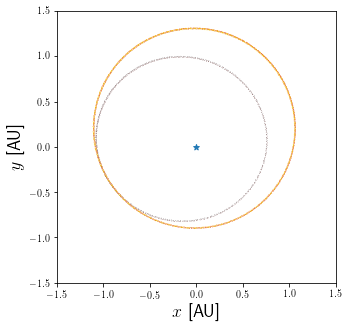

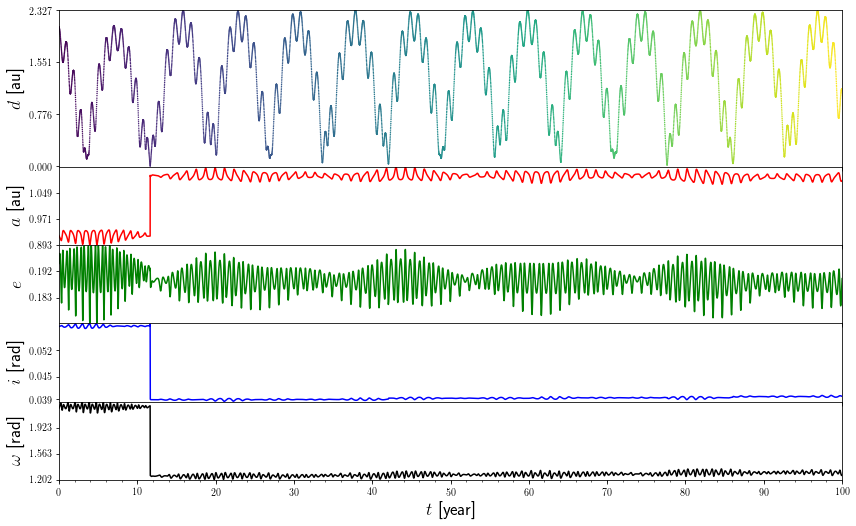

Limit to first 12.0 years for geocentric and rotating frame plot..(1200 steps)


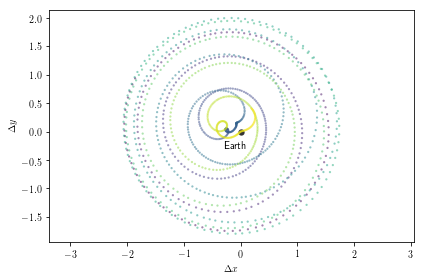

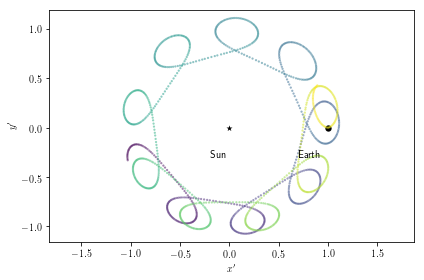

In [14]:
print("Calculate the distance to the Earth...")
times, daeiw = get_daeiw(sa)

t = times/year # in year (not in REBOUND time unit)

print("Plotting...")

# Plot the orbit of Apophis relative to the barycenter
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])

color = t/255.

x = np.zeros(len(sa))
y = np.zeros(len(sa))
for i, sim in enumerate(sa):
    x[i] = sim.particles[-1].x # asteroid - sun
    y[i] = sim.particles[-1].y
    
# cek x vs y saja
plt.scatter(x, y, c=color, s=0.2, lw=0, alpha=1.0, cmap='hot')
plt.scatter([0.0], [0.0], marker='*')
plt.xlabel(r'$x$ [AU]', fontsize=18)
plt.ylabel(r'$y$ [AU]', fontsize=18)
plt.show()

plot_daeiw(t, daeiw)

limitplot = 12.0 # years
lim = int(limitplot/t[-1] * len(sa)) # limit plotting in number of data point
print("Limit to first "+str(limitplot)+" years for geocentric and rotating frame plot..("+str(lim)+" steps)")
plot_geocentric(t, daeiw, lim)
plot_rotatingframe(t, daeiw, lim)

- You can restart or continue your simulation by loading SimulationArchive that you already saved

Related to this problem, you can check also examples on
- how to detect collision (or encounter event)
- chaos (stability) indicatorm Lyapunov, MEGNO
- long integration for Solar System
- ...